Some sources:

* Gensim LDA: https://radimrehurek.com/gensim/models/ldamodel.html
* Misc clustering with Python: http://brandonrose.org/clustering
* Scikit LDA: http://scikit-learn.org/0.16/modules/generated/sklearn.lda.LDA.html
* Scikit NMF: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
* WMD in Python: http://vene.ro/blog/word-movers-distance-in-python.html
* Original WMD paper: http://jmlr.org/proceedings/papers/v37/kusnerb15.pdf

# Make word-doc matrix

In [4]:
import datetime as dt
import os
import sys
import time

In [2]:
from cltk.corpus.greek.tlg.parse_tlg_indices import get_epithet_index
from cltk.corpus.greek.tlg.parse_tlg_indices import get_epithets
from cltk.corpus.greek.tlg.parse_tlg_indices import select_authors_by_epithet
from cltk.corpus.greek.tlg.parse_tlg_indices import get_epithet_of_author
from cltk.corpus.greek.tlg.parse_tlg_indices import get_id_author
from cltk.stop.greek.stops import STOPS_LIST as greek_stops
from cltk.tokenize.word import nltk_tokenize_words

from greek_accentuation.characters import base

import pandas  # pip install pandas

from sklearn.decomposition import NMF  # pip install scikit-learn scipy
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
extra_stops = ["ου", "τος", "τας", "αλλ", "εγω", "εαυτου", "ωσπερ", "τουτων", "οσος", "ουδεν", "καθ", "ος", "αυτον", "αυτην", "αυτους", "εκει", "εαυτου", "τοτε", "τουτου", "μετ", "αυτην", "αυτον", "νυ", "εμοι", "εμε", "παρ", "ταυτ", "πως", "σοι", "αμφι", "αμα", "τουτων", "ισος", "ον", "τε", "τουτ", "τοιαυτην", "εκει", "ρα", "αν1", "και", "δια", "ναι", "αμφι", "τε", "οσος", "ταδε", "τοδε", "ετερος", "ος", "ους", "ρα", "τηϲ", "τοιϲ", "προϲ", "ειϲ", "ανα", "μετ", "ινα", "πα", "επει", "αυτον", "καθ", "ινα", "μυ", "ποτε", "εμε", "ον", "τινα", "μα", "μη", "αυτοι", "αὐτος", "ωδε", "οὐ", "ου", "τος", "μα", "μη", "πυ", "πα", "ον", "ουδ", "ουτ", "μοι", "μος"]

In [22]:
def stream_lemmatized_files(corpus_dir, reject_none_epithet=False, reject_chars_less_than=None):
    # return all docs in a dir; parameters for removing by None epithet and short texts
    user_dir = os.path.expanduser('~/cltk_data/user_data/' + corpus_dir)
    files = os.listdir(user_dir)
    
    map_id_author = get_id_author()

    for file in files:
        filepath = os.path.join(user_dir, file)
        file_id = file[3:-4]
        author = map_id_author[file_id]

        if reject_none_epithet:
            # get id numbers and then epithets of each author
            author_epithet = get_epithet_of_author(file_id)
            if not author_epithet:
                continue

        with open(filepath) as fo:
            
            text = fo.read()
            
            tokens = nltk_tokenize_words(text)
            tokens = [token for token in tokens if token not in extra_stops]
            text = ' '.join(tokens)
            
            if reject_chars_less_than:
                if len(text) < reject_chars_less_than:
                    continue
            
            yield file_id, author, text

In [23]:
t0 = dt.datetime.utcnow()

id_author_text_list = []
for tlg_id, author, text in stream_lemmatized_files('tlg_lemmatized_no_accents_no_stops', 
                                    reject_none_epithet=True,
                                    reject_chars_less_than=500):
    id_author_text_list.append((tlg_id, author, text))

print('... finished in {}'.format(dt.datetime.utcnow() - t0))
print('Number of texts:', len(id_author_text_list))

... finished in 0:02:25.188125
Number of texts: 1137


In [24]:
# view all epithets:
get_epithets()

['Alchemistae',
 'Apologetici',
 'Astrologici',
 'Astronomici',
 'Atticistae',
 'Biographi',
 'Bucolici',
 'Choliambographi',
 'Chronographi',
 'Comici',
 'Doxographi',
 'Elegiaci',
 'Epici/-ae',
 'Epigrammatici/-ae',
 'Epistolographi',
 'Geographi',
 'Geometri',
 'Gnomici',
 'Gnostici',
 'Grammatici',
 'Hagiographi',
 'Historici/-ae',
 'Hymnographi',
 'Iambici',
 'Lexicographi',
 'Lyrici/-ae',
 'Mathematici',
 'Mechanici',
 'Medici',
 'Mimographi',
 'Musici',
 'Mythographi',
 'Nomographi',
 'Onirocritici',
 'Oratores',
 'Paradoxographi',
 'Parodii',
 'Paroemiographi',
 'Periegetae',
 'Philologi',
 'Philosophici/-ae',
 'Poetae',
 'Poetae Didactici',
 'Poetae Medici',
 'Poetae Philosophi',
 'Polyhistorici',
 'Rhetorici',
 'Scriptores Ecclesiastici',
 'Scriptores Erotici',
 'Scriptores Fabularum',
 'Scriptores Rerum Naturalium',
 'Sophistae',
 'Tactici',
 'Theologici',
 'Tragici']

In [25]:
t0 = dt.datetime.utcnow()

# tf-idf features
n_samples = 2000
n_features = 1000  # TODO: increase
n_topics = len(get_epithets())  # 55
n_top_words = 20

tfidf_vectorizer = TfidfVectorizer(max_df=1.0, 
                                   min_df=1,
                                   max_features=n_features,
                                   stop_words=greek_stops)
texts_list = [t[2] for t in id_author_text_list]
tfidf = tfidf_vectorizer.fit_transform(texts_list)

# save features
vector_fp = os.path.expanduser('~/cltk_data/user_data/tlg_lemmatized_no_accents_no_stops_set_reduction_tfidf_{0}features.pickle'.format(n_features))
joblib.dump(tfidf, vector_fp)

print('... finished in {}'.format(dt.datetime.utcnow() - t0))
# time on good server:
# 1000 features: 0:01:22

... finished in 0:00:53.647959


# Run model

In [26]:
t0 = dt.datetime.utcnow()

print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

# save model
nmf_fp = os.path.expanduser('~/cltk_data/user_data/tlg_lemmatized_no_accents_no_stops_set_reduction_tfidf_{0}features_nmf.pickle'.format(n_features))
joblib.dump(nmf, nmf_fp)

print('... finished in {}'.format(dt.datetime.utcnow() - t0))

Fitting the NMF model with tf-idf features, n_samples=2000 and n_features=1000...
... finished in 0:00:09.663657


In [27]:
def print_top_words(model, feature_names, n_top_words):
    for topic_id, topic in enumerate(model.components_):
        print('Topic #{}:'.format(int(topic_id)))
        print(''.join([feature_names[i] + ' ' + str(round(topic[i], 2))
              +' | ' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

In [28]:
print("Topics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

print_top_words(nmf, tfidf_feature_names, n_top_words)

Topics in NMF model:
Topic #0:
ειμι 2.85 | ου 1.01 | εχω 0.95 | τος 0.49 | ποιεω 0.47 | πα 0.37 | οιος 0.36 | τοιου 0.36 | αυτο 0.36 | μονον 0.35 | ολοξ 0.34 | δεω1 0.34 | ος 0.32 | μαλλον 0.31 | φημι 0.31 | ειπον 0.31 | παλιν 0.31 | παντα 0.3 | εαυτου 0.3 | κατ 0.28 | 

Topic #1:
φημι 3.03 | ειμι 0.69 | φησι 0.41 | φησιν 0.36 | λεγει 0.3 | πρωτω 0.27 | γενεσθαι 0.27 | ιστορεω 0.22 | φασι 0.21 | καθα 0.21 | προτερος 0.2 | καλεω 0.19 | διος 0.17 | λεγεται 0.17 | υστερος 0.16 | αθηνη 0.16 | ιερον 0.15 | γουν 0.15 | διο 0.14 | λεγεσθαι 0.14 | 

Topic #2:
ειμι 0.64 | κακοω 0.51 | ανηρ 0.39 | οραω 0.38 | ευ 0.33 | δοκεω 0.32 | κακον 0.31 | εχω 0.29 | απας 0.29 | ζαω 0.28 | ειδον 0.26 | εμεω 0.26 | αγαθος 0.25 | ποτ 0.23 | αει 0.22 | καλος 0.21 | νυ 0.21 | βιον 0.21 | οιδα 0.21 | καν 0.2 | 

Topic #3:
χριστος 0.97 | θεαομαι 0.83 | θεος 0.48 | κυριου 0.4 | ιησου 0.4 | κυριος 0.37 | θεον 0.32 | ου 0.28 | χριστον 0.28 | αγιος 0.28 | υιος 0.27 | ανθρωπος 0.22 | μα 0.22 | πνευ 0.21 | λεγει 0.2 | 

In [29]:
tfidf.shape

(1137, 1000)

In [30]:
doc_topic_distrib = nmf.transform(tfidf)  # numpy.ndarray

In [31]:
doc_topic_distrib.shape

(1137, 55)

In [32]:
df = pandas.DataFrame(doc_topic_distrib)

In [33]:
len(id_author_text_list)

1137

In [34]:
authors_in_order = {index:_tuple[1] for index, _tuple in enumerate(id_author_text_list)}
print(len(authors_in_order))

1137


In [35]:
df = df.rename(authors_in_order)

Questions:

* to what topic does each author most belong? (and how to determine cutoff?)
* what authors most exemplify a topic?

In [36]:
df

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
Lepidus Hist.,0.000000,0.077545,0.000000,0.000000,0.000000,0.000000,0.140505,0.000000,0.000000,0.000000,...,0.000000,0.046851,0.000000,0.050216,0.000000,0.000000,0.000000,0.052111,0.000000,0.000000
Archippus Comic.,0.025486,0.000000,0.029728,0.017143,0.000000,0.000000,0.000000,0.000000,0.000000,0.070260,...,0.000000,0.040257,0.000000,0.081604,0.059330,0.000000,0.000000,0.000000,0.000000,0.000000
Menecrates Hist.,0.001895,0.000000,0.000000,0.016200,0.114572,0.000000,0.000000,0.000000,0.023178,0.006658,...,0.000000,0.000000,0.031162,0.006848,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Marinus Phil.,0.134530,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001926,...,0.000000,0.000000,0.000000,0.065617,0.000000,0.000000,0.000000,0.018619,0.000000,0.000000
Troilus Soph.,0.134120,0.016393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014758,...,0.000000,0.000000,0.000000,0.045456,0.000000,0.000000,0.000000,0.013417,0.012661,0.000462
Apollinaris Theol.,0.094664,0.019815,0.000000,0.306342,0.000000,0.000000,0.000000,0.000000,0.000000,0.001562,...,0.000000,0.000000,0.033674,0.012656,0.000000,0.000000,0.000000,0.000000,0.000000,0.012929
"Hermas Scr. Eccl., Pastor Hermae",0.062739,0.028607,0.016646,0.142850,0.008499,0.000000,0.000000,0.000000,0.000000,0.038199,...,0.000000,0.000000,0.053877,0.046298,0.000000,0.000000,0.000000,0.000000,0.000000,0.014377
Agatharchides Geogr.,0.137694,0.001862,0.000000,0.000000,0.109250,0.030776,0.001100,0.000000,0.000000,0.040167,...,0.000000,0.000000,0.053643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mnaseas Perieg.,0.038388,0.146409,0.000000,0.011157,0.023401,0.000000,0.096971,0.000000,0.000000,0.000000,...,0.000000,0.005002,0.033098,0.000000,0.000000,0.000000,0.000000,0.010700,0.000000,0.041010
Philoxenus Lyr.,0.020419,0.000000,0.033980,0.000000,0.032612,0.002088,0.000000,0.000000,0.010487,0.000000,...,0.000000,0.000000,0.000000,0.065623,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [37]:
# for each topic (col), which author (row) has the highest value?
# TODO: get top 5 authors

for count in range(n_topics):
    print('Top author of topic {0}: {1}'.format(count, df[count].idxmax()))

Top author of topic 0: Iamblichus Phil.
Top author of topic 1: Pythaenetus Hist.
Top author of topic 2: Menander Comic.
Top author of topic 3: Ignatius Scr. Eccl.
Top author of topic 4: Polyaenus Rhet.
Top author of topic 5: Theophilus Protospatharius et Stephanus Atheniensis Med.
Top author of topic 6: Capito Hist.
Top author of topic 7: Glaucus Hist.
Top author of topic 8: Philoxenus Gramm.
Top author of topic 9: Cleopatra Alchem.
Top author of topic 10: Serenus Geom.
Top author of topic 11: Manetho Hist.
Top author of topic 12: [Ctesiphon] Hist.
Top author of topic 13: Metrodorus Major Phil.
Top author of topic 14: Hipparchus Astron. et Geogr.
Top author of topic 15: Lepidus Hist.
Top author of topic 16: Hecataeus Hist.
Top author of topic 17: Lesbonax Gramm.
Top author of topic 18: Sannyrion Comic.
Top author of topic 19: Heliodorus Trag.
Top author of topic 20: Dorotheus Astrol.
Top author of topic 21: Mace(donius) Lyr.
Top author of topic 22: Anaximenes Phil.
Top author of topic 

In [38]:
# Now, transpose df and get top topic of each author
# for each topic (col), which author (row) has the highest value?
# TODO: get top 5 authors
df_t = df.T

In [39]:
#df_t.head(10)
df_t

,Lepidus Hist.,Archippus Comic.,Menecrates Hist.,Marinus Phil.,Troilus Soph.,Apollinaris Theol.,"Hermas Scr. Eccl., Pastor Hermae",Agatharchides Geogr.,Mnaseas Perieg.,Philoxenus Lyr.,...,Machon Comic.,Diodorus Comic.,Thales Phil.,Antiphon Soph.,Hesiodus Epic.,Marcus Aurelius Antoninus Imperator Phil.,Menodotus Hist.,Autolycus Astron.,[Eurytus] Phil.,Nausicrates Comic.
0,0.000000,0.025486,0.001895,0.134530,0.134120,0.094664,0.062739,0.137694,0.038388,0.020419,...,0.063748,0.025606,0.079389,0.123136,0.018573,0.153836,0.064536,0.008671,0.058059,0.012129
1,0.077545,0.000000,0.000000,0.000000,0.016393,0.019815,0.028607,0.001862,0.146409,0.000000,...,0.113954,0.002915,0.126129,0.000000,0.006608,0.000000,0.062359,0.000000,0.000000,0.032806
2,0.000000,0.029728,0.000000,0.000000,0.000000,0.000000,0.016646,0.000000,0.000000,0.033980,...,0.094379,0.126930,0.025713,0.086311,0.014811,0.063613,0.000000,0.000000,0.000000,0.055223
3,0.000000,0.017143,0.016200,0.000000,0.000000,0.306342,0.142850,0.000000,0.011157,0.000000,...,0.000000,0.000000,0.006252,0.000000,0.000000,0.000000,0.013519,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.114572,0.000000,0.000000,0.000000,0.008499,0.109250,0.023401,0.032612,...,0.013136,0.003546,0.045434,0.000000,0.000000,0.000735,0.044541,0.000258,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030776,0.000000,0.002088,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.140505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001100,0.096971,0.000000,...,0.000838,0.031375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.051502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.023178,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010487,...,0.000000,0.011687,0.013369,0.000000,0.006185,0.000000,0.000000,0.000000,0.000000,0.048946
9,0.000000,0.070260,0.006658,0.001926,0.014758,0.001562,0.038199,0.040167,0.000000,0.000000,...,0.052709,0.013778,0.000000,0.000000,0.040468,0.000000,0.015800,0.000000,0.006230,0.000000


In [40]:
map_name_epithet_id = {}
for curr_name in df_t.columns:
    print(curr_name)
    try:
        top_topic = int(df_t[curr_name].idxmax())
    except TypeError:  # there are some duplicate names, just take one value for now
        top_topic = int(df_t[curr_name].idxmax().iloc[0])    
    print('    NMF topic:', top_topic)
    for _id, name in get_id_author().items():
        if curr_name == name:
            epithet = get_epithet_of_author(_id)
            print('    Traditional epithet:', epithet)
            map_name_epithet_id[name] = {'id': _id,
                                        'top_topic': top_topic,
                                        'epithet': epithet}
    print()

Lepidus Hist.
    NMF topic: 6
    Traditional epithet: Historici/-ae

Archippus Comic.
    NMF topic: 48
    Traditional epithet: Comici

Menecrates Hist.
    NMF topic: 4
    Traditional epithet: Historici/-ae
    Traditional epithet: Historici/-ae
    Traditional epithet: Historici/-ae
    Traditional epithet: Historici/-ae
    Traditional epithet: Historici/-ae

Marinus Phil.
    NMF topic: 0
    Traditional epithet: Philosophici/-ae

Troilus Soph.
    NMF topic: 0
    Traditional epithet: Sophistae

Apollinaris Theol.
    NMF topic: 3
    Traditional epithet: Theologici

Hermas Scr. Eccl., Pastor Hermae
    NMF topic: 3
    Traditional epithet: Scriptores Ecclesiastici

Agatharchides Geogr.
    NMF topic: 0
    Traditional epithet: Geographi

Mnaseas Perieg.
    NMF topic: 1
    Traditional epithet: Periegetae

Philoxenus Lyr.
    NMF topic: 48
    Traditional epithet: Lyrici/-ae
    Traditional epithet: Lyrici/-ae

Boethus Phil.
    NMF topic: 0
    Traditional epithet: Philosoph

Now let's look at the variations of the respective clusters, nmf topic and epithets

* Question: Which topics are found within each epithet?
* Question: Which epithets are found within each topic? And how many?

## Topics w/in each epithet

In [41]:
# Group by epithet, collect topics
# {<epithet>: [<topics>]}
from collections import defaultdict

map_epithet_topics = defaultdict(list)
for name, _dict in map_name_epithet_id.items():
    epithet = _dict['epithet']
    top_topic = _dict['top_topic']
    map_epithet_topics[epithet].append(top_topic)

In [72]:
from collections import Counter

In [73]:
all_epithet_stats = []
for epithet, topics in map_epithet_topics.items():
    total_docs = len(topics)
    unique_topics = len(set(topics))
    c = Counter(topics)
    most_common_topic = c.most_common()[0][0]
    topic_diversity = unique_topics / total_docs
    epithet_stats = {'epithet': epithet,
                    'total_docs': total_docs,
                    'unique_topics': unique_topics,
                    'most_common_topic': most_common_topic,
                    'topic_diversity': topic_diversity}
    all_epithet_stats.append(epithet_stats)

In [74]:
df = pandas.DataFrame(all_epithet_stats)
df

,epithet,most_common_topic,topic_diversity,total_docs,unique_topics
0,Lyrici/-ae,24,0.466667,30,14
1,Theologici,3,0.111111,36,4
2,Scriptores Fabularum,0,1.000000,2,2
3,Atticistae,17,0.750000,4,3
4,Elegiaci,24,0.500000,16,8
5,Sophistae,0,0.307692,39,12
6,Medici,5,0.302326,43,13
7,Philosophici/-ae,0,0.172775,191,33
8,Polyhistorici,6,1.000000,1,1
9,Apologetici,3,0.444444,9,4


In [43]:
# which epithet has the most topics associated with it?
# That is, what epithet is most topic-lexical diverse?
#? Perhaps do simple lex diversity count
map_epithet_count_topics = {}
for epithet, topic_list in map_epithet_topics.items():
    map_epithet_count_topics[epithet] = len(topic_list)

sorted(map_epithet_count_topics.items(), key=lambda x:x[1], reverse=True)

[('Historici/-ae', 246),
 ('Philosophici/-ae', 191),
 ('Comici', 91),
 ('Grammatici', 52),
 ('Scriptores Ecclesiastici', 45),
 ('Medici', 43),
 ('Rhetorici', 40),
 ('Sophistae', 39),
 ('Theologici', 36),
 ('Lyrici/-ae', 30),
 ('Epici/-ae', 30),
 ('Alchemistae', 20),
 ('Poetae', 19),
 ('Tragici', 19),
 ('Elegiaci', 16),
 ('Astronomici', 13),
 ('Astrologici', 10),
 ('Epigrammatici/-ae', 10),
 ('Oratores', 10),
 ('Apologetici', 9),
 ('Biographi', 9),
 ('Mathematici', 9),
 ('Paradoxographi', 9),
 ('Geographi', 9),
 ('Periegetae', 9),
 ('Scriptores Erotici', 8),
 ('Mechanici', 7),
 ('Philologi', 6),
 ('Tactici', 6),
 ('Chronographi', 6),
 ('Poetae Philosophi', 6),
 ('Iambici', 5),
 ('Mythographi', 5),
 ('Paroemiographi', 5),
 ('Gnomici', 4),
 ('Atticistae', 4),
 ('Geometri', 4),
 ('Musici', 4),
 ('Poetae Medici', 4),
 ('Epistolographi', 3),
 ('Parodii', 3),
 ('Bucolici', 3),
 ('Scriptores Fabularum', 2),
 ('Mimographi', 2),
 ('Onirocritici', 2),
 ('Lexicographi', 2),
 ('Doxographi', 2),
 ('

## Epithets per topic

In [78]:
# Group by topic, collect epithets
# {<topic>: [<epithets>]}
from collections import defaultdict

map_topic_epithets = defaultdict(list)
for name, _dict in map_name_epithet_id.items():
    epithet = _dict['epithet']
    top_topic = _dict['top_topic']
    map_topic_epithets[top_topic].append(epithet)

In [79]:
#dict(map_topic_epithets)

In [87]:
all_topic_stats = []
for topic, epithets in map_topic_epithets.items():
    total_epithets = len(epithets)
    unique_epithets = len(set(epithets))
    c = Counter(epithets)
    most_common_epithet = c.most_common()[0][0]
    epithet_diversity = unique_epithets / total_epithets
    topic_stats = {'topic': topic,
                    'total_epithets': total_epithets,
                    'unique_epithets': unique_epithets,
                    'most_common_epithet': most_common_epithet,
                    'epithet_diversity': epithet_diversity}
    all_topic_stats.append(topic_stats)
df = pandas.DataFrame(all_topic_stats)
df

,epithet_diversity,most_common_epithet,topic,total_epithets,unique_epithets
0,0.150000,Philosophici/-ae,0,220,33
1,0.155172,Historici/-ae,1,58,9
2,0.195122,Comici,2,82,16
3,0.150000,Scriptores Ecclesiastici,3,80,12
4,0.198020,Historici/-ae,4,101,20
5,0.250000,Medici,5,24,6
6,0.307692,Historici/-ae,6,26,8
7,0.375000,Historici/-ae,7,8,3
8,0.500000,Grammatici,8,8,4
9,0.466667,Comici,9,15,7


## Scale

In [47]:
# http://scikit-learn.org/stable/modules/clustering.html

In [48]:
dataset_array = df.values
print(dataset_array.dtype)  # kmeans needs to be homogeneous data type (here, float64)
print(dataset_array)

float64
[[ 0.          0.07754461  0.         ...,  0.05211096  0.          0.        ]
 [ 0.02548641  0.          0.02972809 ...,  0.          0.          0.        ]
 [ 0.00189544  0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.00867074  0.          0.         ...,  0.          0.          0.        ]
 [ 0.05805867  0.          0.         ...,  0.02279445  0.          0.01446624]
 [ 0.0121291   0.03280637  0.05522277 ...,  0.07019141  0.          0.        ]]


In [49]:
# do I need to normalize
# sklearn.preprocessing.StandardScaler
from sklearn import preprocessing

In [50]:
# http://scikit-learn.org/stable/modules/preprocessing.html
# first load scaler and train on given data set
scaler = preprocessing.StandardScaler().fit(df)

In [51]:
scaler.mean_

array([ 0.0639107 ,  0.02206707,  0.02361666,  0.02155623,  0.03145717,
        0.00959372,  0.00949862,  0.00283346,  0.00625861,  0.01442603,
        0.00782186,  0.00699223,  0.00509698,  0.01207509,  0.00380417,
        0.        ,  0.00992889,  0.00691232,  0.00760987,  0.00698809,
        0.00660643,  0.00808588,  0.00734069,  0.00820843,  0.02221089,
        0.00686544,  0.00855114,  0.00840206,  0.0062374 ,  0.00624706,
        0.00876823,  0.00764493,  0.00616411,  0.00627384,  0.00651731,
        0.00654287,  0.00611768,  0.00367595,  0.00275596,  0.00610676,
        0.00440088,  0.00564217,  0.00815183,  0.00510205,  0.00572966,
        0.0067771 ,  0.00520184,  0.00837632,  0.02419492,  0.00366645,
        0.00382704,  0.00390222,  0.00726048,  0.00194177,  0.00729314])

In [52]:
scaler.scale_

array([ 0.05106243,  0.03582592,  0.03948377,  0.06083138,  0.04919305,
        0.03384145,  0.03714104,  0.01990953,  0.01783294,  0.0221736 ,
        0.0421719 ,  0.03406048,  0.0335237 ,  0.01944899,  0.03253641,
        1.        ,  0.02284901,  0.03248277,  0.02033699,  0.02494378,
        0.03668578,  0.01923089,  0.03363376,  0.02506177,  0.04900518,
        0.02263181,  0.03005846,  0.02013287,  0.01961547,  0.01652482,
        0.01911399,  0.02305398,  0.02197301,  0.02830076,  0.03561409,
        0.0185194 ,  0.0256628 ,  0.0271646 ,  0.03425089,  0.01766238,
        0.02620198,  0.01905279,  0.02961475,  0.01937339,  0.02275314,
        0.02988567,  0.02079399,  0.02185304,  0.02424164,  0.02160777,
        0.02403703,  0.02386364,  0.01974146,  0.03035562,  0.01976598])

In [53]:
t0 = dt.datetime.utcnow()

# actually do normalization; can be reused for eg a training set
df_scaled = pandas.DataFrame(scaler.transform(df))

print('... finished in {}'.format(dt.datetime.utcnow() - t0))

... finished in 0:00:00.001808


# Visualize topic clusters

In [54]:
from sklearn import cluster

In [55]:
# Convert DataFrame to matrix (numpy.ndarray)
matrix = df_scaled.as_matrix()

km = cluster.KMeans(n_clusters=n_topics)
km.fit(matrix)

# Get cluster assignment labels
labels = km.labels_  # these are the topics 0-54; array([53, 53, 16, ..., 42, 16, 13]

# Format results as a DataFrame
df_clusters = pandas.DataFrame([df_scaled.index, labels]).T  # add author names to the 0 col

In [56]:
df_clusters.head(5)

,0,1
0,0,8
1,1,52
2,2,46
3,3,7
4,4,7


In [57]:
%matplotlib inline
import matplotlib.pyplot as plt  # pip install matplotlib
import matplotlib
matplotlib.style.use('ggplot')

# from pandas.tools.plotting import table

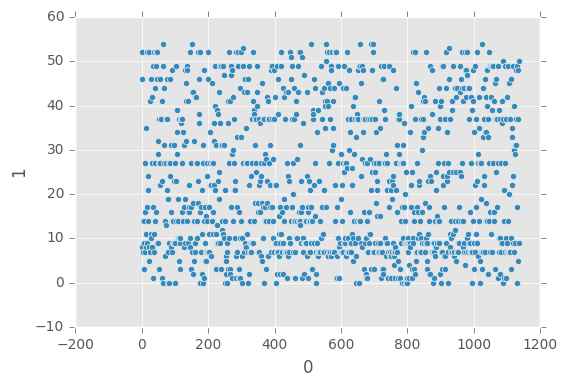

In [58]:
# this is a cluseter of the already-clustered kmeans topics; not very informative
plt.figure()
df_clusters.plot.scatter(x=0, y=1)  # y is topics no., x is doc id

## Kmeans based tfidf matrix

In [59]:
# try clustering the original tfidf
# tfidf_dense = tfidf.toarray()
scaler = preprocessing.StandardScaler(with_mean=False).fit(tfidf) # either with_mean=False or make dense

# save scaler
scaler_fp = os.path.expanduser('~/cltk_data/user_data/tlg_lemmatized_no_accents_no_stops_tfidf_{0}features_scaler.pickle'.format(n_features))
joblib.dump(df_scaled, scaler_fp)

['/root/cltk_data/user_data/tlg_lemmatized_no_accents_no_stops_tfidf_1000features_scaler.pickle']

In [60]:
import numpy as np

In [61]:
# direct Pandas conversion of sparse scipy matrix not supported
# Following http://stackoverflow.com/a/17819427
# df_scaled_tfidf = pandas.DataFrame(scaler.transform(tfidf))
# df_scaled_tfidf = pandas.DataFrame()

t0 = dt.datetime.utcnow()

scaler_tfidf = scaler.transform(tfidf)  # sparse matrix of type '<class 'numpy.float64'>
pandas.SparseDataFrame([pandas.SparseSeries(scaler_tfidf[i].toarray().ravel()) for i in np.arange(scaler_tfidf.shape[0])])
df_scaled_tfidf = pandas.SparseDataFrame([pandas.SparseSeries(scaler_tfidf[i].toarray().ravel()) for i in np.arange(scaler_tfidf.shape[0])])
# type(df)  # pandas.sparse.frame.SparseDataFrame

print('... finished in {}'.format(dt.datetime.utcnow() - t0))

... finished in 0:00:19.331312


In [62]:
t0 = dt.datetime.utcnow()

# Convert DataFrame to matrix (numpy.ndarray)
matrix_tfidf = df_scaled_tfidf.as_matrix()

km_tfidf = cluster.KMeans(n_clusters=n_topics)
km_tfidf.fit(matrix_tfidf)

# Get cluster assignment labels
labels = km_tfidf.labels_  # these are the topics 0-54; array([53, 53, 16, ..., 42, 16, 13]

# Format results as a DataFrame
df_clusters_tfidf = pandas.DataFrame([df_scaled_tfidf.index, labels]).T  # add author names to the 0 col

print('... finished in {}'.format(dt.datetime.utcnow() - t0))

... finished in 0:00:04.447597


In [63]:
df_clusters_tfidf.head(10)

,0,1
0,0,12
1,1,3
2,2,29
3,3,24
4,4,24
5,5,2
6,6,2
7,7,32
8,8,29
9,9,37


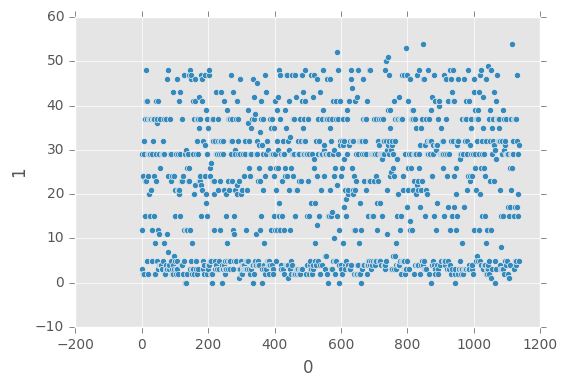

In [64]:
plt.figure()
df_clusters_tfidf.plot.scatter(x=0, y=1)  # y is topics no., x is doc id

## Kmeans based on nmf

In [65]:
nmf_array = nmf.components_

In [66]:
t0 = dt.datetime.utcnow()

# nmf_dense = nmf_array.toarray()
scaler = preprocessing.StandardScaler().fit(nmf_array) # either with_mean=False or make dense

# save features
tfidf_matrix_scaler_fp = os.path.expanduser('~/cltk_data/user_data/tlg_lemmatized_no_accents_no_stops_tfidf_matrix_{0}features.pickle'.format(n_features))
joblib.dump(scaler, tfidf_matrix_scaler_fp)

print('... finished in {}'.format(dt.datetime.utcnow() - t0))

... finished in 0:00:00.002474


In [67]:
df_scaled_nmf = pandas.DataFrame(scaler.transform(nmf_array))

In [68]:
# Convert DataFrame to matrix (numpy.ndarray)
matrix_nmf = df_scaled_nmf.as_matrix()

km_nmf = cluster.KMeans(n_clusters=n_topics)
km_nmf.fit(matrix_nmf)

# Get cluster assignment labels
labels = km_nmf.labels_  # these are the clusters 0-54; array([ 1,  4, 11, 14, 28,  9, 30,

# Format results as a DataFrame
df_clusters_nmf = pandas.DataFrame([df_scaled_nmf.index, labels]).T  # add author names to the 0 col

In [69]:
df_clusters_nmf.head(10)

,0,1
0,0,1
1,1,14
2,2,9
3,3,4
4,4,2
5,5,6
6,6,23
7,7,12
8,8,37
9,9,18


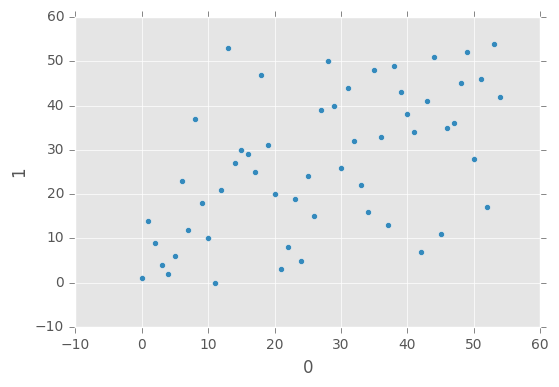

In [70]:
plt.figure()
df_clusters_nmf.plot.scatter(x=0, y=1)  #axis?